## 3.2autograd
PyTorch在autograd模块中实现了计算图的相关功能，autograd中的核心数据结构是Variable。从v0.4版本起，Variable和Tensor合并。**我们可以认为需要求导(requires_grad)的tensor即Variable. autograd记录对tensor的操作记录用来构建计算图。**

In [1]:
from __future__ import print_function
import torch as t

In [6]:
#指定参数求导
a = t.randn(3, 4, requires_grad=True)
#或者
a = t.randn(3, 4).requires_grad_()
#或者
a = t.randn(3, 4)
#或者
a.requires_grad=True
a


tensor([[-0.6820, -1.1406, -0.2632,  1.3969],
        [-1.2451,  0.8250,  0.9740, -0.4491],
        [ 0.2748, -0.8826, -1.5438,  1.3043]], requires_grad=True)

In [7]:
b = t.zeros(3, 4, requires_grad=True)
b

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]], requires_grad=True)

In [9]:
c = a + b
c

tensor([[-0.6820, -1.1406, -0.2632,  1.3969],
        [-1.2451,  0.8250,  0.9740, -0.4491],
        [ 0.2748, -0.8826, -1.5438,  1.3043]], grad_fn=<AddBackward0>)

In [11]:
d = c.sum()
d.backward()#BP

In [13]:
d
d.requires_grad

True

In [28]:
#输出
print("a_grad", a.grad)
print("b_grad", b.grad)
print("c_grad", c.grad)

a_grad tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])
b_grad tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])
c_grad None


In [29]:
a.requires_grad, b.requires_grad, c.requires_grad

(True, True, True)

In [31]:
a.is_leaf, b.is_leaf, c.is_leaf

(True, True, False)

In [32]:
c.grad is None


True

### 手动计算和自动求导的区别

In [40]:
#1. 定义函数
def f(x):
    
    y = x**2*t.exp(x)
    
    return y
def grad(x):
    
    dx = 2*x*t.exp(x) + t.pow(x, 2)*t.exp(x)
    
    return dx

In [44]:
#数据
x = t.randn(3, 4, requires_grad=True)
y = f(x)
y.shape

torch.Size([3, 4])

In [42]:
#自动求导
y.backward(t.ones(y.size()))
x.grad

tensor([[-0.4541, -0.2696, -0.4004, 15.5897],
        [13.3898, -0.0868, -0.4555,  5.1220],
        [-0.4346, 11.3173, 19.6205, -0.4297]])

In [43]:
#手动求导
grad(x)

tensor([[-0.4541, -0.2696, -0.4004, 15.5897],
        [13.3898, -0.0868, -0.4555,  5.1220],
        [-0.4346, 11.3173, 19.6205, -0.4297]], grad_fn=<AddBackward0>)

### 计算图

![](http://localhost:8888/notebooks/Pytorch/documents/pytorch-book/chapter3-Tensor%E5%92%8Cautograd/imgs/com_graph.svg)

In [92]:
x = t.ones(1)
b = t.rand(1, requires_grad=True)
w = t.rand(1, requires_grad=True)
y = w * x
z = y + b
x.requires_grad, b.requires_grad,w.requires_grad

(False, True, True)

In [93]:
y.requires_grad

True

In [94]:
x.is_leaf, b.is_leaf, w.is_leaf, y.is_leaf, z.is_leaf

(True, True, True, False, False)

In [95]:
print(z.grad_fn)
print(y.grad_fn)

In [96]:
#查看输入函数
z.grad_fn.next_functions

((<MulBackward0 at 0x7fb56811f6a0>, 0),
 (<AccumulateGrad at 0x7fb56811f0f0>, 0))

In [97]:
y.grad_fn.next_functions

((<AccumulateGrad at 0x7fb56811f748>, 0), (None, 0))

In [98]:
#叶子节点的grad_fn是None
w.grad_fn, x.grad_fn

(None, None)

In [104]:
#使用retain_graph来保存ｂｕｆｆｅｒ
z.backward(retain_graph=True)

In [105]:
#z.backwa

w.grad

tensor([5.])

In [108]:
z.backward()#此时会把图进拆解
w.grad

RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

In [109]:
#x为正数字
def abs(x):
    if x.data[0]>0 : return x
    else: return -x
    
x = t.ones(1, requires_grad=True)
y = abs(x)
y.backward()#计算一次反向传播
print("x.grad", x.grad)
print("y.grad_fn", y.grad_fn)

x.grad tensor([1.])
y.grad_fn None


In [115]:
#x为负数
x = -1*t.ones(1, requires_grad=True)
print("x = ", x)
y = abs(x)
y.backward()#计算一次反向传播
print("x.grad", x.grad)
print("y.grad_fn", y.grad_fn)

x =  tensor([-1.], grad_fn=<MulBackward0>)
x.grad None
y.grad_fn <NegBackward object at 0x7fb568116f28>


In [117]:
def f(x):
    result = 1
    for ii in x:
        if ii.item() > 0 : result = result*ii
    return result
x = t.arange(-2, 4,dtype=t.float32,requires_grad=True)
y = f(x)
y.backward()
x.grad

tensor([0., 0., 0., 6., 3., 2.])

In [118]:
x = t.ones(1, requires_grad=True)
w = t.rand(1, requires_grad=True)
y = x * w
# y依赖于w，而w.requires_grad = True
x.requires_grad, w.requires_grad, y.requires_grad

(True, True, True)

In [122]:
with t.no_grad():
    x = t.ones(1)
    w = t.rand(1, requires_grad=True)
    y = x * w
x.requires_grad, y.requires_grad, w.requires_grad

(False, False, True)

In [133]:
y.backward??## 查询函数

SyntaxError: invalid syntax (<ipython-input-133-e9e5a4b6f4f8>, line 1)

In [134]:
t.set_grad_enabled(False)
x = t.ones(1)
w = t.rand(1, requires_grad=True)
y = x*w
y.requires_grad, w.requires_grad, x.requires_grad

(False, True, False)

In [135]:
#恢复自动求导
t.set_grad_enabled(True)

In [138]:
a = t.rand(3, 4, requires_grad=True)
b = t.rand(3, 4, requires_grad=True)
c = a*b
a.data

tensor([[0.1625, 0.9512, 0.8686, 0.8218],
        [0.9146, 0.3558, 0.8892, 0.7035],
        [0.2928, 0.1099, 0.5888, 0.8292]])

In [139]:
a.data.requires_grad

False

In [140]:
d = a.data.sigmoid_()
d.requires_grad

False

In [148]:
tensor = a.detach()
tensor.requires_grad

False

In [151]:
#统计指标
mean = tensor.mean()
std = tensor.std()
maximum = tensor.max()
mean, std, maximum

(tensor(0.7599), tensor(0.1858), tensor(1.))

In [157]:
tensor[0] = 1 

In [158]:
#反向传播过程中的梯度清零
x = t.ones(3, requires_grad=True)
w = t.rand(3, requires_grad=True)

y = x * w
# y依赖于w，而w.requires_grad = True
z = y.sum()
x.requires_grad, w.requires_grad, y.requires_grad

(True, True, True)

In [159]:
#非叶子节点，自动清零
z.backward()
(x.grad, y.grad, w.grad)

(tensor([0.7177, 0.5782, 0.0062]), None, tensor([1., 1., 1.]))

In [160]:
# 第一种方法：使用grad获取中间变量的梯度
x = t.ones(3, requires_grad=True)
w = t.rand(3, requires_grad=True)
y = x * w
z = y.sum()
# z对y的梯度，隐式调用backward()
t.autograd.grad(z, y)

(tensor([1., 1., 1.]),)

In [162]:
def variable_hook(grad):
    print('y的梯度：',grad)

x = t.ones(3, requires_grad=True)
w = t.rand(3, requires_grad=True)
y = x * w

hook_handle = y.register_hook(variable_hook)
z = y.sum()
z.backward()

hook_handle.remove()

y的梯度： tensor([1., 1., 1.])


In [164]:
x = t.arange(0, 3,dtype=t.float32, requires_grad=True)
y = x**2 + x*2
z = y.sum()
z.backward()
x.grad

tensor([2., 4., 6.])

In [170]:
#从指定位置开始梯度下降算法
x = t.arange(0, 3,dtype=t.float32, requires_grad=True)
y = x**2 + x*2
z = y.sum()
print(z)
y_gradient = t.Tensor([1, 1, 1])#dz/dy
y.backward(y_gradient)
x.grad


tensor(11., grad_fn=<SumBackward0>)


tensor([2., 4., 6.])

### 扩展autograd

In [8]:
from torch.autograd import Function

class MultiplyAdd(Function):
    
    @staticmethod
    def forward(ctx, w, x, b):
        ctx.save_for_backward(w, x)#临时保存来使得反向传播更好
        output = w*x + b
        return output
    
    @staticmethod
    def backward(ctx, grad_output):#此处的grad_output表示前一个梯度
        w, x = ctx.saved_tensors
        grad_w = grad_output * x
        grad_x = grad_output * w
        grad_b = grad_output * 1
        
        return grad_w, grad_x, grad_b

In [9]:
#测试手写的前向传播和反向传播
x = t.ones(1)
w = t.rand(1, requires_grad=True)
b = t.rand(1, requires_grad=True)

#前向传播
z = MultiplyAdd.apply(w, x, b)
#反向传播
z.backward()

#
x.grad, w.grad, b.grad

(None, tensor([1.]), tensor([1.]))

In [12]:
x = t.ones(1)
w = t.rand(1, requires_grad = True)
b = t.rand(1, requires_grad = True)
#print('开始前向传播')
z=MultiplyAdd.apply(w,x,b)

z.grad_fn.apply(t.ones(1))

(tensor([1.]), tensor([0.8561], grad_fn=<MulBackward0>), tensor([1.]))

In [14]:
x = t.tensor([5],dtype=t.float32, requires_grad=True)
y = x**2
grad_x = t.autograd.grad(y, x, create_graph=True)
grad_x

(tensor([10.], grad_fn=<MulBackward0>),)

In [15]:
grad_grad_x = t.autograd.grad(grad_x[0], x)
grad_grad_x

(tensor([2.]),)

### Sigmoid函数的构造

In [17]:
class Sigmoid(Function):
    
    @staticmethod
    def forward(ctx, x):
        output = 1/(1 + t.exp(-x))
        ctx.save_for_backward(output)
        return output
    
    @staticmethod
    def backward(ctx, grad_output):
        output, = ctx.saved_tensors
        grad_x = output * (1 - output) *grad_output

In [63]:
test_input = t.randn(3, 4,dtype=t.double, requires_grad=True)
t.autograd.gradcheck(Sigmoid.apply, (test_input,), eps=1e-2)

RuntimeError: Jacobian mismatch for output 0 with respect to input 0,
numerical:tensor([[0.2499, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.1980, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.2498, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.1939, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.1096, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2479, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2372, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2327, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1477,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.2500, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.2211, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.2485]], dtype=torch.float64)
analytical:tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)


In [64]:
def f_sigmoid(x):
    y = Sigmoid.apply(x)
    y.backward(t.ones(x.size()))
    
def f_naive(x):
    y =  1/(1 + t.exp(-x))
    y.backward(t.ones(x.size()))
    
def f_th(x):
    y = t.sigmoid(x)
    y.backward(t.ones(x.size()))
    
x=t.randn(100, 100, requires_grad=True)
%timeit -n 100 f_sigmoid(x)
%timeit -n 100 f_naive(x)
%timeit -n 100 f_th(x)

263 µs ± 55.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
225 µs ± 17 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
The slowest run took 5.66 times longer than the fastest. This could mean that an intermediate result is being cached.
192 µs ± 151 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### 小试牛刀：线性回归

In [65]:
import torch as t
%matplotlib inline
from matplotlib import pyplot as plt
from IPython import display 
import numpy as np

In [66]:
t.manual_seed(1000)

def get_fake_data(batch_size = 8):
    
    ''' 随机数据加上一定的噪声'''
    x = t.rand(batch_size, 1) * 5
    y = x * 2 + 3 +t.randn(batch_size, 1)
    
    return x, y

Text(0.5, 1.0, 'Scatter picture')

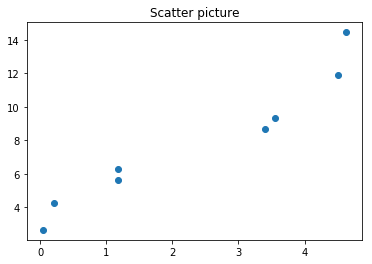

In [70]:
# 得到数据
x, y = get_fake_data()
plt.scatter(x.squeeze().numpy(), y.squeeze().numpy())
plt.title("Scatter picture")

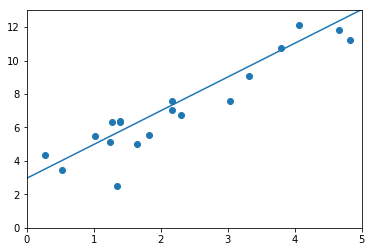

2.0162365436553955 2.9727535247802734


In [104]:
#开始构建线性梯度值
#1.数据预处理
w = t.rand(1, 1,dtype=t.float32, requires_grad=True)
b = t.rand(1, 1, requires_grad=True)

losses = np.zeros(1000)#用来保存一次迭代的loss值

lr = 0.001

for ii in range(1000):
    #得到数据
    x, y = get_fake_data(32)
    
    #forward
    y_pred = t.relu(x.mm(w) + b.expand_as(y))
    loss = 0.5 * (y_pred - y)**2#最小二乘法
    loss = loss.sum()
    losses[ii] = loss
    
    #backward
    loss.backward()
    
    #更新参数(torch.data表示只能够进行数值修改，但是不会改变autograd)
    w.data.sub_(lr * w.grad.data)
    b.data.sub_(lr * b.grad.data)
    
    #梯度清零(notice)
    w.grad.data.zero_()
    b.grad.data.zero_()
    #print("w = ",w.grad, "b = ", b.grad)
    if ii%50 == 0:
        display.clear_output(wait=True)
        x = t.arange(0, 6, dtype=t.float32).view(-1, 1)
        y = x.mm(w.data) + b.data.expand_as(x)
        plt.plot(x.numpy(), y.numpy())
        
        x2 , y2 = get_fake_data(batch_size=20)
        plt.scatter(x2.numpy(), y2.numpy())
        
        
        plt.xlim(0, 5)
        plt.ylim(0, 13)
        plt.show()
        plt.pause(0.5)
        
print(w.item(), b.item())
#print(losses)

(5, 200)

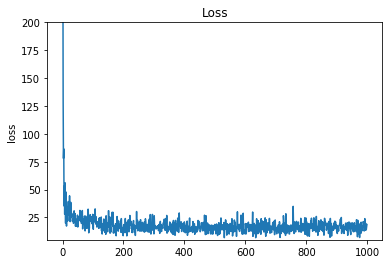

In [107]:
plt.plot(losses)#默认以列表下标为x轴
plt.title("Loss")
plt.ylabel("loss")
plt.ylim(5, 200)